# Import Libraries

In [1]:
import os
import sys

util_path = os.path.abspath(os.path.join('..'))

if util_path not in sys.path:
    sys.path.append(util_path)

import utility_func as util
import importlib
importlib.reload(util)

<module 'utility_func' from 'D:\\GitUpload\\CMT-GSC-AI\\utility_func.py'>

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

### Train Data

In [3]:
curr_dir = (os.getcwd()).replace('\\', '/')
curr_dir = os.path.abspath(os.path.join(curr_dir, '..'))
data_path = (os.path.join(curr_dir, 'Data')).replace('\\', '/')

In [4]:
str_sed_data = util.pd.read_csv(data_path + '/Ramagiri dataset/proc_stream_sediments_57F11.csv')

In [5]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,ho,er,tm,yb,lu,hf,ta,u,toposheet,hg
0,2947,2947,57F11/177/SS/12,77.657407,14.475225,61.921,14.606,4.51,0.05,2.28,...,0.730795,2.139445,0.359742,2.290226,0.413697,26.874492,0.677483,3.016905,57F11,8.0
1,2948,2948,57F11/178/SS/12,77.675926,14.475225,62.077,13.750,4.22,0.05,2.43,...,0.783322,2.405519,0.419132,2.891123,0.500104,37.079419,0.774466,3.378550,57F11,9.0
2,2949,2949,57F11/179/SS/12,77.694444,14.475225,68.645,13.410,3.23,0.05,1.32,...,0.651000,1.919000,0.329000,2.323000,0.423000,23.652000,0.715000,3.509000,57F11,2.5
3,2951,2951,57F11/181/SS/12,77.731481,14.475225,64.302,14.010,4.08,0.05,1.84,...,0.655000,2.042000,0.334000,2.322000,0.431000,26.705000,0.832000,4.218000,57F11,15.0
4,2952,2952,57F11/182/SS/12,77.749999,14.475225,64.346,14.940,5.25,0.07,1.38,...,0.650000,1.978000,0.320000,2.311000,0.403000,23.323999,0.739000,3.882000,57F11,12.0


# EDA

In [6]:
str_elem = util.elem_list(str_sed_data)
len(str_elem)

53

In [7]:
elem_df = str_sed_data[str_elem]
elem_df.head()

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,dy,ho,er,tm,yb,lu,hf,ta,u,hg
0,61.921,14.606,4.51,0.05,2.28,3.24,1.52,2.46,0.61,0.13,...,3.725699,0.730795,2.139445,0.359742,2.290226,0.413697,26.874492,0.677483,3.016905,8.0
1,62.077,13.750,4.22,0.05,2.43,4.14,1.52,2.55,0.64,0.12,...,4.140085,0.783322,2.405519,0.419132,2.891123,0.500104,37.079419,0.774466,3.378550,9.0
2,68.645,13.410,3.23,0.05,1.32,3.19,2.89,3.08,0.75,0.08,...,3.404000,0.651000,1.919000,0.329000,2.323000,0.423000,23.652000,0.715000,3.509000,2.5
3,64.302,14.010,4.08,0.05,1.84,3.24,2.12,2.83,0.75,0.16,...,3.475000,0.655000,2.042000,0.334000,2.322000,0.431000,26.705000,0.832000,4.218000,15.0
4,64.346,14.940,5.25,0.07,1.38,2.59,2.31,2.95,1.05,0.17,...,3.457000,0.650000,1.978000,0.320000,2.311000,0.403000,23.323999,0.739000,3.882000,12.0


# Feature Selection

## Split into train, validation and test data

In [8]:
train_df = elem_df.copy()
target = elem_df['as_']
train_df.drop(['as_'], axis=1, inplace=True)

In [54]:
X_train, X_test, y_train, y_test = util.train_test_split(train_df, 
                                                         target, 
                                                         test_size=0.1, 
                                                         random_state=42, 
                                                         shuffle=True)

In [55]:
X_train, X_val, y_train, y_val = util.train_test_split(X_train, 
                                                       y_train, 
                                                       test_size=0.1, 
                                                       random_state=42, 
                                                       shuffle=True)

## Normalize

In [56]:
rs = util.RobustScaler()

norm_data = rs.fit_transform(X_train)

X_train_norm = util.pd.DataFrame(norm_data, 
                                 index=X_train.index, 
                                 columns=X_train.columns)

## Estimator: Random Forest

In [57]:
rf = util.RandomForestRegressor()
rfecv_rf = util.rfecv(rf, X_train_norm, y_train, 1, 5)

In [58]:
print('Optimal number of features: {}'.format(rfecv_rf.n_features_))

Optimal number of features: 12


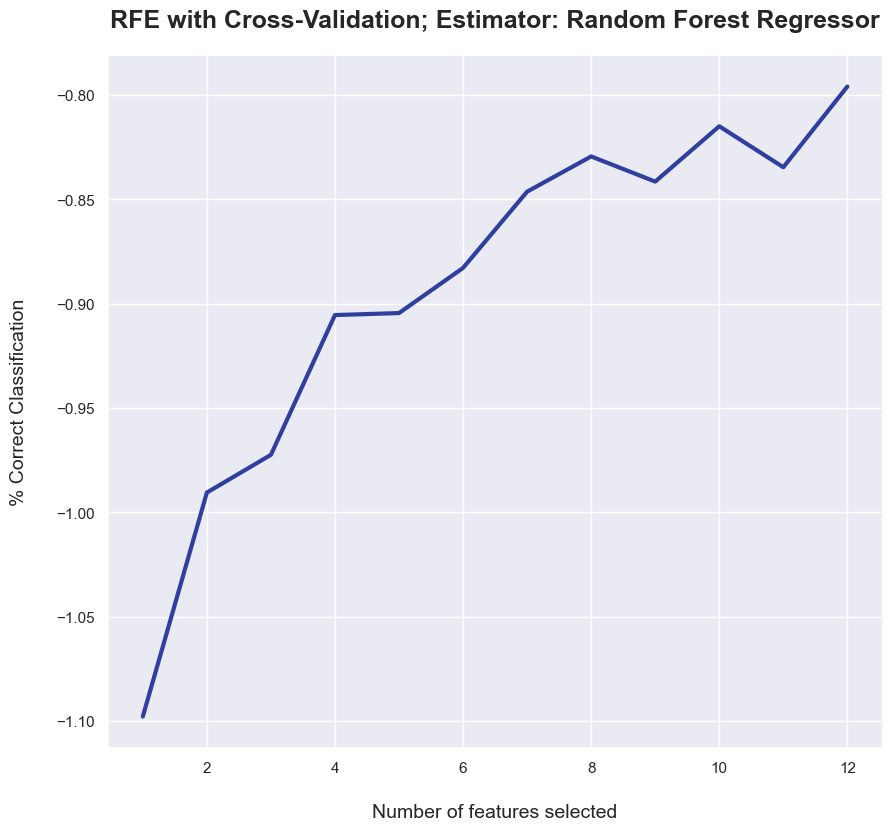

In [59]:
util.plot_pcc(rfecv_rf, 'RFE with Cross-Validation; Estimator: Random Forest Regressor')

In [60]:
X_rf = X_train_norm.drop(X_train_norm.columns[util.np.where(rfecv_rf.support_ == False)[0]], axis=1)

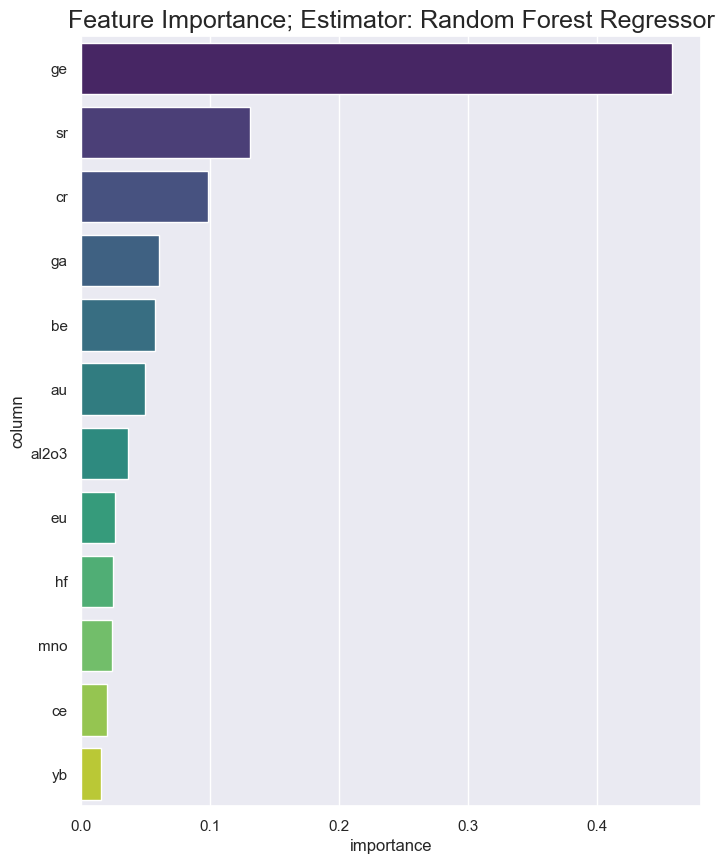

In [61]:
util.feature_importance(rfecv_rf, X_rf, 'Feature Importance; Estimator: Random Forest Regressor')

# Model Training

In [62]:
train_df = elem_df[X_rf.columns]

In [63]:
X_train, X_test, y_train, y_test = util.train_test_split(train_df, 
                                                         target, 
                                                         test_size=0.1, 
                                                         random_state=42,
                                                         shuffle=True)

In [64]:
X_train, X_val, y_train, y_val = util.train_test_split(X_train, 
                                                       y_train, 
                                                       test_size=0.1, 
                                                       random_state=42,
                                                       shuffle=True)

In [65]:
rs = util.RobustScaler()

norm_data = rs.fit_transform(X_train)

X_train_norm = util.pd.DataFrame(norm_data, 
                                 index=X_train.index, 
                                 columns=X_train.columns)

## Random Forest

In [66]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': [1, 2, 3, 4, 'sqrt'],   # Number of features to consider at every split
    'max_depth': [10, 20, 30],    # Maximum number of levels in each tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]              # Minimum number of samples required at each leaf node
}

rf = util.RandomForestRegressor()

grid_search_rfr_rf = util.GridSearchCV(rf, 
                                       param_grid, 
                                       cv=5, 
                                       scoring='neg_mean_absolute_error', 
                                       verbose=5, 
                                       n_jobs=-1)

grid_search_rfr_rf.fit(X_train_norm, y_train)

# Get the best hyperparameters
best_params = grid_search_rfr_rf.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Best Hyperparameters: {'max_depth': 30, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


### Run the models on validation data 

In [67]:
y_pred_val = util.pred_val(X_val, rs, grid_search_rfr_rf)

In [68]:
util.eval_model(y_val, y_pred_val, 'Validation set', X_train_norm.shape[0], X_train_norm.shape[1])

Validation set
Root Mean Squared Error: 1.36
Mean Absolute Error: 0.95
R-squared Error: 0.75
Adjusted R-squared Error: 0.73


In [69]:
y_pred = util.pred_val(X_test, rs, grid_search_rfr_rf)

In [70]:
util.eval_model(y_test, y_pred, 'Test set', X_train_norm.shape[0], X_train_norm.shape[1])

Test set
Root Mean Squared Error: 0.98
Mean Absolute Error: 0.66
R-squared Error: -1.23
Adjusted R-squared Error: -1.41


### Learning curve

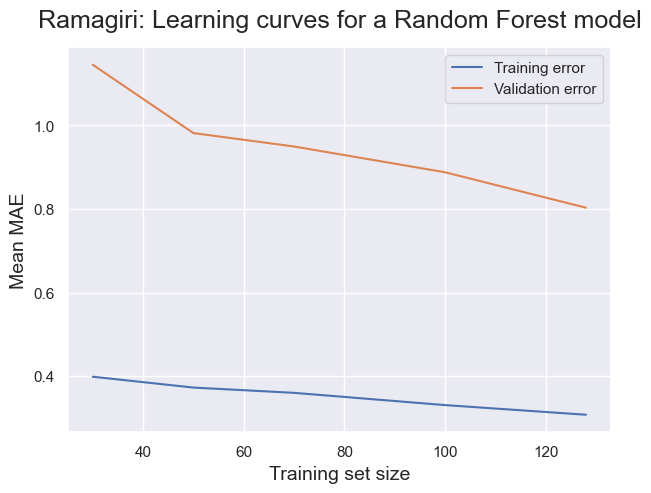

In [75]:
util.plot_learing_curve(util.RandomForestRegressor(max_depth=30, 
                                                   max_features=4, 
                                                   min_samples_leaf=1, 
                                                   min_samples_split=2, 
                                                   n_estimators=300), 
                        X_train_norm, y_train, 5, 'Random Forest', 'Ramagiri')

In [73]:
plot_vals = util.pd.DataFrame({
    'Identifier': y_test.index,
    'Actual': y_test,
    'Predicted': y_pred
})

plot_vals = plot_vals.sort_values(by='Identifier')

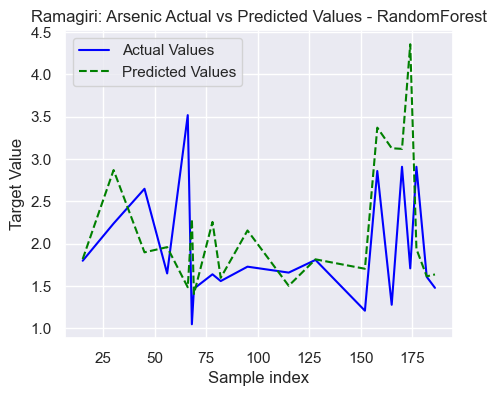

In [74]:
util.plt.figure(figsize=(5, 4))
util.plt.plot(plot_vals['Actual'], label='Actual Values', color='blue')
util.plt.plot(plot_vals['Predicted'], label='Predicted Values', color='green', linestyle='--')
util.plt.title('Ramagiri: Arsenic Actual vs Predicted Values - RandomForest')
util.plt.xlabel('Sample index')
util.plt.ylabel('Target Value')
util.plt.legend()
util.plt.grid(True)
util.plt.show()

## XGBoost

In [29]:
param_grid = {
    'n_estimators': [100, 200, 300],    
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 5, 7],          
    'colsample_bytree': [0.5, 0.7, 1.0], 
    'subsample': [0.5, 0.7, 1.0],        
    'gamma': [0.1, 0.2],             
    'reg_alpha': [0.5, 1],       
    'reg_lambda': [0.5, 1],           
    'objective': ['reg:squarederror']
}

xgb = util.xgboost.XGBRegressor()

grid_search_xgb_rf = util.GridSearchCV(xgb, 
                                       param_grid, 
                                       cv=5, 
                                       scoring='neg_mean_absolute_error', 
                                       verbose=5, 
                                       n_jobs=-1)

grid_search_xgb_rf.fit(X_train_norm, y_train)

# Get the best hyperparameters
best_params = grid_search_xgb_rf.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'objective': 'reg:squarederror', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 0.7}


### Run the models on validation data

In [30]:
y_pred_val = util.pred_val(X_val, rs, grid_search_xgb_rf)

In [31]:
util.eval_model(y_val, y_pred_val, 'Validation set', X_train_norm.shape[0], X_train_norm.shape[1])

Validation set
Root Mean Squared Error: 1.34
Mean Absolute Error: 0.82
R-squared Error: 0.76
Adjusted R-squared Error: 0.74


In [32]:
y_pred = util.pred_val(X_test, rs, grid_search_xgb_rf)

In [33]:
util.eval_model(y_test, y_pred, 'Test set', X_train_norm.shape[0], X_train_norm.shape[1])

Test set
Root Mean Squared Error: 1.05
Mean Absolute Error: 0.71
R-squared Error: -1.54
Adjusted R-squared Error: -1.75


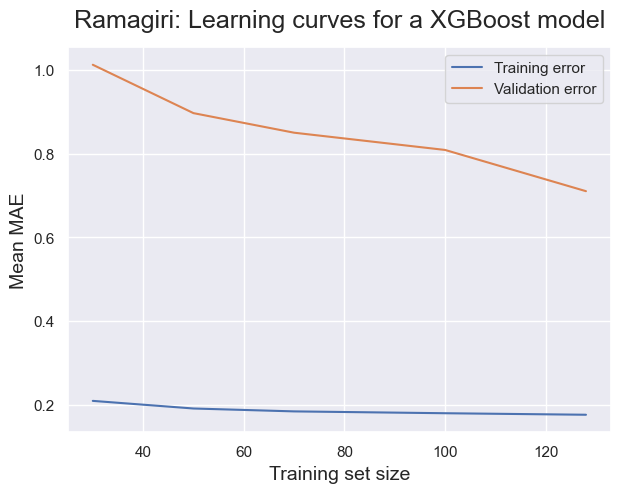

In [38]:
util.plot_learing_curve(util.xgboost.XGBRegressor(colsample_bytree=1.0, 
                                                  gamma=0.2, 
                                                  learning_rate=0.05, 
                                                  max_depth=5, 
                                                  n_estimators=300, 
                                                  objective='reg:squarederror', 
                                                  reg_alpha=0.5, 
                                                  reg_lambda=0.5, 
                                                  subsample=0.7), 
                        X_train_norm, y_train, 5, 'XGBoost', 'Ramagiri')

In [34]:
plot_vals = util.pd.DataFrame({
    'Identifier': y_test.index,
    'Actual': y_test,
    'Predicted': y_pred
})

plot_vals = plot_vals.sort_values(by='Identifier')

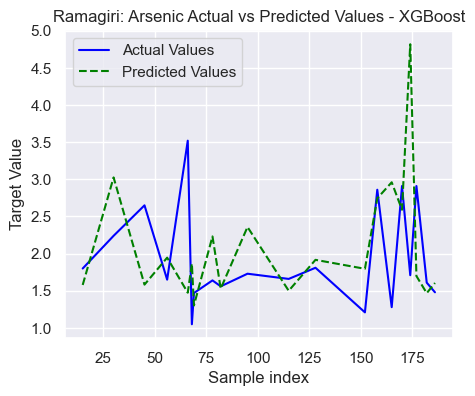

In [35]:
util.plt.figure(figsize=(5, 4))
util.plt.plot(plot_vals['Actual'], label='Actual Values', color='blue')
util.plt.plot(plot_vals['Predicted'], label='Predicted Values', color='green', linestyle='--')
util.plt.title('Ramagiri: Arsenic Actual vs Predicted Values - XGBoost')
util.plt.xlabel('Sample index')
util.plt.ylabel('Target Value')
util.plt.legend()
util.plt.grid(True)
util.plt.show()

# Saving the models

In [41]:
model_path = (os.path.join(curr_dir, 'Models/Ramagiri/')).replace('\\', '/')

In [76]:
## Robust Scaler model
with open(model_path + 'rs_norm_as_.pkl', 'wb') as file:
    util.pkl.dump(rs, file)

# Random Forest with RF estimator
with open(model_path + 'RFR_RF_as_.pkl', 'wb') as file:
    util.pkl.dump(grid_search_rfr_rf, file)

# XGBoost with RF estimator
with open(model_path + 'XGB_RF_as_.pkl', 'wb') as file:
    util.pkl.dump(grid_search_xgb_rf, file)

In [78]:
X_train_norm_df = util.pd.DataFrame(X_train_norm.columns, columns=['Elements'])
with util.pd.ExcelWriter(data_path + '/Ramagiri dataset/Ramagiri_element_names.xlsx', engine='openpyxl', mode='a') as writer:
    X_train_norm_df.to_excel(writer, sheet_name='Arsenic', index=False)